<h1>Proyecto Capstone - IBM Coursera

<h2> Batalla de los Vecindarios

<h3> Sebastián Larrea Carpio.

## Tabla de contenidos
* [Introducción: Problema Comercial](#introducción)
* [Datos](#datos)
* [Metodología](#metodología)
* [Análisis](#análisis)
* [Resultados y discución](#resultados)
* [Conclusiones](#conclusiones)

## Introducción: Problema Comercial <a name="introducción"></a>

Una **industria hotelera** desea abrir una nueva **cadena de hoteles** de 4 y 5 estrellas en la ciudad de **Los Ángeles- California, Estados Unidos**

Para ello requieren realizar un **análisis de datos** para determinar el **mejor sector**, barrio o calle en la que se deben situar los hoteles, para que las **ganancias económicas** crezcan exponencialmente, y la satisfacción de los usuarios sea la mejor posible, provocando las **recomendaciones** hacia más personas para que visiten el hotel, las **condiciones que se plantean** para que el hotel sea rentable son las siguientes:
*	Debe estar situado cerca de lugares turísticos.
*	Debe estar situado cerca de restaurantes y sitios de comida.
*	Debe estar situada cerca de playas y lugares de descanso.
*	Se debe evitar zonas peligrosas en donde los clientes puedan sufrir de robos o agresiones.*

Bajo estas consideraciones se debe realizar el estudio de datos y determinar el mejor lugar disponible para la construcción del hotel.


## Datos <a name="datos"></a>

Para la obtención de los datos, se realizó una **minería de información**, donde se recopilaron todos los vecindarios existentes en la ciudad de Los Ángeles, con **un total de 194 vecindarios** pertenecientes a esta ciudad y su distrito, toda esta información fue almacenada en una hoja de cálculo.

Con esta base de datos, se procedió a implementar la aplicación **Geocode**, (Complemento de Google Sheets), para obtener la **información geográfica de latitud y longitud** de cada uno de los 194 vecindarios, información necesaria que se utilizara más adelante **en conjunto con Foursquare** para adquirir toda la información de cada vecindario.

Con esta base de datos, se procedió a al entendimiento y limpieza del Data Frame.

#### Importe de librerías necesarias para el estudio

In [36]:
import numpy as np # librería para manejar datos vectorizados

import pandas as pd # librería para análisis de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # librería para manejar archivos JSON 

 # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare 
from geopy.geocoders import Nominatim # convertir una dirección en valores de latitud y longitud

import requests # librería para manejar solicitudes
from pandas.io.json import json_normalize # librería para convertir un archivo json en un dataframe pandas
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Matplotlib y módulos asociados para graficar
import matplotlib.cm as cm
import matplotlib.colors as colors

# importar k-means desde la fase de agrupación
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare
import folium # librería para graficar mapas 

Carga del conjunto de datos de los vecinadarios de la ciudad de Los Ángeles, al Notebook de trabajo como Data Frame.

In [8]:
df = pd.read_excel ('datos_la.xlsx')
df.head()

,Vecindario,Ciudad,Full Address,Latitud,Longitud
0,Angelino Heights,Los Angeles,Angelino Heights Los Angeles,34.0413,-118.1517
1,Angeles Mesa,Los Angeles,Angeles Mesa Los Angeles,33.9942,-118.3136
2,Angelus Vista,Los Angeles,Angelus Vista Los Angeles,34.0469,-118.3176
3,Arleta,Los Angeles,Arleta Los Angeles,34.2419,-118.4255
4,Arlington Heights,Los Angeles,Arlington Heights Los Angeles,34.0232,-118.1908


Se comprobó que el conjunto de datos contenga los 194 vecindarios.

In [9]:
df.shape

(194, 5)

Obtención de las coordenadas geográficas de la ciudad de Los Ángeles, mediante el geolocator.

In [10]:
address = 'Los Angeles, California'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.242766.


Con la obtención de las coordenadas de la ciudad, y con la ayuda de las coordenadas de cada vecindario que obtuvimos previamente en la preparación del conjunto de datos con Geocode, procedemos a realizar un mapa con cada vecindario superpuesto, de la ciudad de Los Ángeles.

In [11]:
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# añadir marcadores al mapa
for lat, lng, ciudad, vecindario in zip(df['Latitud'], df['Longitud'], df['Ciudad'], df['Vecindario']):
    label = '{}, {}'.format(ciudad, vecindario)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

### Limpieza de los datos

Para un mejor manejo del data frame, se realizo la eliminación de columnas como "ciudad", ya está entendido que se realiza en el estudio en la ciudad de Los Ángeles, porque esta redundante su permanencia en este.

Por otro lado, la columna "Full Address", fue utilizada para la obtención de la latitud y longitud de los vecindarios, por lo que su propósito fue cumplido y no se la necesita más para el estudio.


In [12]:
df2 = df.drop(['Full Address','Ciudad'],axis=1)
df2.head()

,Vecindario,Latitud,Longitud
0,Angelino Heights,34.0413,-118.1517
1,Angeles Mesa,33.9942,-118.3136
2,Angelus Vista,34.0469,-118.3176
3,Arleta,34.2419,-118.4255
4,Arlington Heights,34.0232,-118.1908


Con la ayuda del mapa superpuesto con los todos los vecindarios de la ciudad, aplicamos una de las condiciones primordiales para la implementación de este nuevo hotel:

**Debe estar situada cerca de playas y lugares de descanso.**

Ya que no todos los vecindarios poseen una salida costera, no será necesario realizar un análisis a profundidad de cada uno, y solo se lo realizara en los vecindarios de Pacific Palisades, Venice, Marina Península, Playa del Rey, San Pedro y Wilmington, que cumplen con esta importante condición.


In [13]:
vecin = df2['Vecindario'] == 'Pacific Palisades'
df3 = df2[vecin]
vecin2=df2['Vecindario'] == 'Venice'
df4=df2[vecin2]
vecin3=df2['Vecindario'] == 'Marina Peninsula'
df5=df2[vecin3]
vecin4=df2['Vecindario'] == 'Playa del Rey'
df6=df2[vecin4]
vecin5=df2['Vecindario'] == 'San Pedro'
df7=df2[vecin5]
vecin6=df2['Vecindario'] == 'Wilmington'
df8=df2[vecin6]
df_vecin=pd.concat([df3,df4,df5,df6,df7,df8])
df_vecin.head(6)

,Vecindario,Latitud,Longitud
119,Pacific Palisades,34.035633,-118.515590
165,Venice,33.985047,-118.469483
99,Marina Peninsula,33.979698,-118.465657
127,Playa del Rey,33.956419,-118.442232
135,San Pedro,33.736062,-118.292246
188,Wilmington,33.785795,-118.264357


Como resultado obtuvimos un Data Frame, con 6 vecindarios, listos para realizar su estudio uno por uno en la siguiente sección.

In [14]:
df_vecin.shape

(6, 3)

## Metodología <a name="metodología"></a>

En este proyecto se realizará un **enfoque estadístico** para determinar cuál de los **6 vecindarios** propuestos de la ciudad de Los Ángeles (Pacific Palisades, Venice, Marina Península, Playa del Rey, San Pedro y Wilmington), es el **más adecuado** para la implementación del **nuevo hotel**, para esto utilizaremos la **herramienta de Foursquare**, que nos proporcionara la **información de cada uno de los 6 vecindarios**, en un radio de 500 metros.

Una vez con esta información y realizado el análisis estadístico, se determinará cual vecindario cumple con las condiciones establecidas en un principio, una vez escogido, a este vecindario **se implementará un modelo** de aprendizaje automático, denominado **K-means**, que **agrupará la información turística y sitios de interés*, y nos permitirá visualizar el mejor sector turístico del vecindario mediante un mapa de Folium

Para terminar, **se realizará el análisis y discusión** del modelo implementado en **el vecindario** y se tomará la decisión de que sector **cumple con todas las condiciones establecidas**, y además **se recomendará el mejor sitio turístico y de interés** del vecindario seleccionado.


## Análisis <a name="análisis"></a>

Para comenzar con el análisis de los datos y su Data Frame, estableces nuestras credenciales para el acceso a la API de Foursquare. (Fueron cortadas del Notebook, por seguridad).

In [15]:
CLIENT_ID = 'GACSOFOELO3VYZCTIT4TIFLNMOY1XEFMBPPGSWGPCAVE4BWQ' # su ID de Foursquare
CLIENT_SECRET = 'TQI4R4UMQPZHFARDRKPSBLFQBROJEQPZFNPIGIBN4R5ZERJK' # Secreto de Foursquare
VERSION = '20180605' # versión de la API de Foursquare
LIMIT = 100 # Un valor límite para la API de Foursquare

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GACSOFOELO3VYZCTIT4TIFLNMOY1XEFMBPPGSWGPCAVE4BWQ
CLIENT_SECRET:TQI4R4UMQPZHFARDRKPSBLFQBROJEQPZFNPIGIBN4R5ZERJK


A continuación definimos las funciones que nos permitiran ingresar a la API de Foursquare, y obtener la información de lugares de interés de cada uno de los vecindarios.

In [16]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # solicitud GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # regresa solo información relevante de cada sitio cercano
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [21]:
Los_Angeles_venues = getNearbyVenues(names=df_vecin['Vecindario'],
                                   latitudes=df_vecin['Latitud'],
                                   longitudes=df_vecin['Longitud']
                                  )

Pacific Palisades
Venice
Marina Peninsula
Playa del Rey
San Pedro
Wilmington


Una vez ejecutada las funciones de obtención de los datos, podemos observar el nuevo Data Frame, contiene todos los sitios de interés de cada uno de los 6 vecindarios.

In [22]:
print(Los_Angeles_venues.shape)
Los_Angeles_venues.head()

(139, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pacific Palisades,34.035633,-118.51559,Palisades Stairs,34.035182,-118.517632,Trail
1,Pacific Palisades,34.035633,-118.51559,Earth-Friendly Air Duct Cleaning Pacific Palis...,34.036491,-118.518509,Home Service
2,Pacific Palisades,34.035633,-118.51559,Sumac Stairs,34.032727,-118.514766,Trail
3,Pacific Palisades,34.035633,-118.51559,Rustic Canyon Stairs,34.032458,-118.515108,Athletics & Sports
4,Pacific Palisades,34.035633,-118.51559,Christina's Genie In A Bottle,34.031401,-118.514952,Arcade


Determinamos cuantas categorías únicas de sitios de interés tenemos, con un total de 79 diferentes categorías.

In [23]:
print('Hay {} categorias unicas.'.format(len(Los_Angeles_venues['Venue Category'].unique())))

Hay 79 categorias unicas.


### Analisis por cada vecindario

A continuación, se procede a realizar el análisis por cada vecindario, para ello convertimos el Data Frame de manera que se visualiza cada categoría encontrada en Foursquare por vecindario.

In [24]:
# codificación
Los_Angeles_onehot = pd.get_dummies(Los_Angeles_venues[['Venue Category']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
Los_Angeles_onehot['Neighborhood'] = Los_Angeles_venues['Neighborhood'] 

# mover la columna de barrio a la primer columna
fixed_columns = [Los_Angeles_onehot.columns[-1]] + list(Los_Angeles_onehot.columns[:-1])
Los_Angeles_onehot = Los_Angeles_onehot[fixed_columns]
print(Los_Angeles_onehot.shape)
Los_Angeles_onehot.head(140)

(139, 80)


,Neighborhood,ATM,American Restaurant,Arcade,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Bike Trail,Board Shop,Breakfast Spot,Burger Joint,Café,Canal,Candy Store,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Dessert Shop,Doctor's Office,Donut Shop,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Laundromat,Liquor Store,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Moroccan Restaurant,New American Restaurant,Park,Pedestrian Plaza,Pharmacy,Pier,Pizza Place,Playground,Plaza,Restaurant,Sandwich Place,Scenic Lookout,Shipping Store,Skate Park,Sporting Goods Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Trail,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Wings Joint,Yoga Studio
0,Pacific Palisades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Pacific Palisades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pacific Palisades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Pacific Palisades,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Pacific Palisades,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Pacific Palisades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Venice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Venice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Venice,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Venice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Contamos cauntos sitios de interés posee cada Vecindario.

In [34]:
count = Los_Angeles_onehot['Neighborhood'].value_counts()
count.head(6)


Marina Peninsula     44
San Pedro            34
Venice               24
Playa del Rey        24
Wilmington            7
Pacific Palisades     6
Name: Neighborhood, dtype: int64

Para entender mejor esta tabla realizamos un gráfico de barras.

<AxesSubplot:xlabel='Sitios', ylabel='Vecindario'>

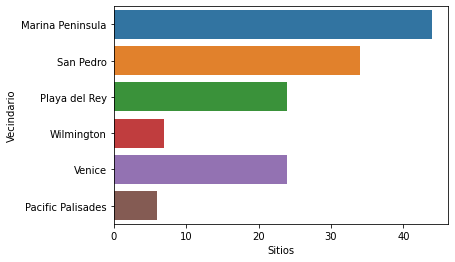

In [40]:
lst1 = ["Marina Peninsula","San Pedro","Playa del Rey","Wilmington","Venice","Pacific Palisades"]
lst2 = [44,34,24,7,24,6]
count2 = pd.DataFrame(list(zip(lst1,lst2)), columns = ['Vecindario','Sitios'])
count2.head(6)
sns.barplot(y='Vecindario', x='Sitios', data=count2, orient="h")

Despues agrupamos por vecindario y obtenemos la frecuencia de cada categoría única en los 6 vecindarios.

In [41]:
Los_Angeles_grouped = Los_Angeles_onehot.groupby('Neighborhood').mean().reset_index()
print(Los_Angeles_grouped.shape)
Los_Angeles_grouped

(6, 80)


,Neighborhood,ATM,American Restaurant,Arcade,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Bike Trail,Board Shop,Breakfast Spot,Burger Joint,Café,Canal,Candy Store,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Dessert Shop,Doctor's Office,Donut Shop,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Laundromat,Liquor Store,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Moroccan Restaurant,New American Restaurant,Park,Pedestrian Plaza,Pharmacy,Pier,Pizza Place,Playground,Plaza,Restaurant,Sandwich Place,Scenic Lookout,Shipping Store,Skate Park,Sporting Goods Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Trail,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Wings Joint,Yoga Studio
0,Marina Peninsula,0.000000,0.068182,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.045455,0.022727,0.022727,0.022727,0.022727,0.045455,0.022727,0.022727,0.000000,0.000000,0.022727,0.022727,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.045455,0.022727,0.000000,0.000000,0.000000,0.022727,0.022727,0.000000,0.045455,0.000000,0.022727,0.000000,0.045455,0.022727,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.022727,0.000000,0.022727,0.000000,0.000000,0.000000,0.022727,0.022727,0.022727,0.000000,0.022727,0.022727,0.022727
1,Pacific Palisades,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
2,Playa del Rey,0.000000,0.041667,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.041667,0.000000,0.041667,0.000000,0.000000,0.041667,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.041667,0.083333,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.041667,0.041667,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.041667,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,San Pedro,0.058824,0.000000,0.000000,0.000000,0.000000,0.029412,0.029412,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.058824,0.029412,0.000000,0.000000,0.000000,0.088235,0.029412,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.088235,0.029412,0.029412,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000
4,Venice

Mostramos 10 categorías únicas con mas frecuencia en cada barrio, acompañado de un gráfico de barras para entender mejor estos datos.

----Marina Peninsula----
                 venue  freq
0  American Restaurant  0.07
1                Hotel  0.05
2                  Bar  0.05
3   Italian Restaurant  0.05
4   Mexican Restaurant  0.05
5         Burger Joint  0.05
6                Beach  0.05
7    Food & Drink Shop  0.05
8     Sushi Restaurant  0.02
9  Japanese Restaurant  0.02




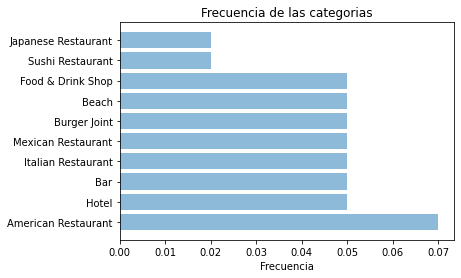

----Pacific Palisades----
                venue  freq
0               Trail  0.33
1              Arcade  0.17
2  Athletics & Sports  0.17
3        Home Service  0.17
4          Food Truck  0.17
5                 ATM  0.00
6  Mexican Restaurant  0.00
7            Pharmacy  0.00
8    Pedestrian Plaza  0.00
9                Park  0.00




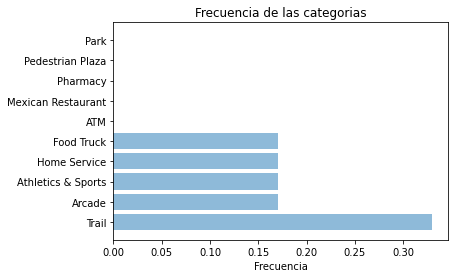

----Playa del Rey----
                  venue  freq
0           Pizza Place  0.08
1           Coffee Shop  0.08
2  Gym / Fitness Center  0.08
3          Liquor Store  0.04
4        Shipping Store  0.04
5           Flower Shop  0.04
6         Deli / Bodega  0.04
7            Laundromat  0.04
8        Cosmetics Shop  0.04
9                  Park  0.04




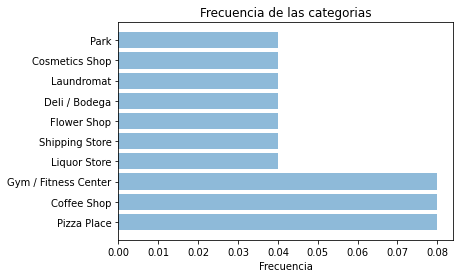

----San Pedro----
                 venue  freq
0   Mexican Restaurant  0.09
1          Coffee Shop  0.09
2                  ATM  0.06
3   Italian Restaurant  0.06
4             Pharmacy  0.06
5          Pizza Place  0.06
6       Sandwich Place  0.06
7         Burger Joint  0.06
8  Sporting Goods Shop  0.03
9       Ice Cream Shop  0.03




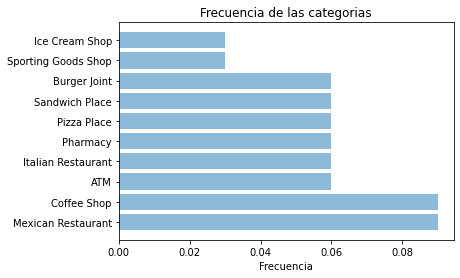

----Venice----
                 venue  freq
0  American Restaurant  0.08
1          Coffee Shop  0.08
2                Hotel  0.04
3     Sushi Restaurant  0.04
4   Mexican Restaurant  0.04
5            Hotel Bar  0.04
6            Gastropub  0.04
7     Pedestrian Plaza  0.04
8           Playground  0.04
9                Plaza  0.04




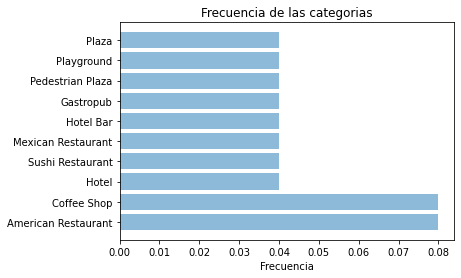

----Wilmington----
                      venue  freq
0        Mexican Restaurant  0.14
1                    Market  0.14
2           Doctor's Office  0.14
3                Donut Shop  0.14
4              Burger Joint  0.14
5                  Tea Room  0.14
6             Deli / Bodega  0.14
7            Massage Studio  0.00
8  Mediterranean Restaurant  0.00
9      Marijuana Dispensary  0.00




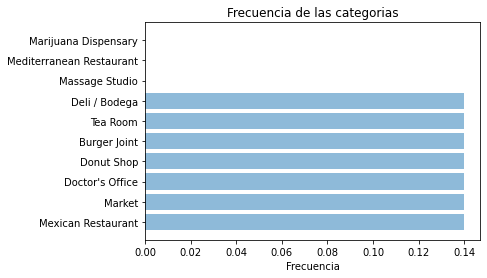

In [42]:
num_top_venues = 10

for hood in Los_Angeles_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Los_Angeles_grouped[Los_Angeles_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
    temp2=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)

    
    y_pos = np.arange(len(temp2['venue']))

    #Creamos la grafica pasando los valores en el eje X, Y, donde X = cantidad_usos y Y = lenguajes
    plt.barh(y_pos, temp2['freq'], align='center', alpha=0.5)
    #Añadimos la etiqueta de nombre de cada lenguaje en su posicion correcta
    plt.yticks(y_pos, temp2['venue'])
    #añadimos una etiqueta en el eje X
    plt.xlabel('Frecuencia')
    #Y una etiqueta superior
    plt.title('Frecuencia de las categorias')
    plt.savefig('barras_horizontal.png')
    plt.show()

   

Creamos otro Data Frame que nos permita visualizar las 10 categorías únicas o sitios más populares de cada barrio.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Los_Angeles_grouped['Neighborhood']

for ind in np.arange(Los_Angeles_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Los_Angeles_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(6)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marina Peninsula,American Restaurant,Hotel,Bar,Beach,Italian Restaurant,Burger Joint,Mexican Restaurant,Food & Drink Shop,Food,Japanese Restaurant
1,Pacific Palisades,Trail,Home Service,Arcade,Athletics & Sports,Food Truck,Yoga Studio,Fast Food Restaurant,Cuban Restaurant,Deli / Bodega,Dessert Shop
2,Playa del Rey,Coffee Shop,Pizza Place,Gym / Fitness Center,Mexican Restaurant,Mediterranean Restaurant,Massage Studio,Cosmetics Shop,Liquor Store,Laundromat,Deli / Bodega
3,San Pedro,Coffee Shop,Mexican Restaurant,Sandwich Place,Burger Joint,Pharmacy,ATM,Italian Restaurant,Pizza Place,Liquor Store,Convenience Store
4,Venice,American Restaurant,Coffee Shop,Hotel,Board Shop,Hotel Bar,Farmers Market,Dessert Shop,Marijuana Dispensary,Mexican Restaurant,Chinese Restaurant
5,Wilmington,Deli / Bodega,Burger Joint,Mexican Restaurant,Doctor's Office,Tea Room,Donut Shop,Market,Yoga Studio,Farmers Market,Cuban Restaurant


### Primer análisis

Una vez aplicado distintos métodos estadísticos para realizar un **análisis exploratorio de los datos**, (ver la sección de resultados y discusión), se puede determinar y **eliminar vecindarios**, que en **comparación con otros** se encuentran con **desventajas** basándonos en las condiciones establecidas previamente, por lo que el mejor vecindario elegido es el de **Marina Peninsula**.

### Implementación del modelo de aprendizaje automático

Con el vecindario seleccionado de Marina Península como el que cumple de mejor manera con todas las condiciones establecidas, se procede a realizar la implementación del modelo de aprendizaje automático, K-means, para determinar el mejor sector dentro del vecindario donde se recomendaría la construcción del hotel.

In [45]:
Marina_Peninsula_df=Los_Angeles_venues.drop(Los_Angeles_venues[Los_Angeles_venues['Neighborhood'] !=  'Marina Peninsula'].index)
Marina_Peninsula_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
30,Marina Peninsula,33.979698,-118.465657,The Studio (MDR),33.980738,-118.463800,Gym / Fitness Center
31,Marina Peninsula,33.979698,-118.465657,Cold Stone Creamery,33.979513,-118.465731,Ice Cream Shop
32,Marina Peninsula,33.979698,-118.465657,The Cow's End Cafe,33.979602,-118.465845,Café
33,Marina Peninsula,33.979698,-118.465657,Hinano Cafe,33.979499,-118.466516,Burger Joint
34,Marina Peninsula,33.979698,-118.465657,Arbor,33.979754,-118.465363,Board Shop


Establecemos las condiciones del modelo con un total de 5 agrupaciones.

In [46]:
# establecer el número de agrupaciones
kclusters = 5

Los_Angeles_grouped_clustering = Marina_Peninsula_df.drop(['Neighborhood','Venue','Venue Category'], 1)

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Los_Angeles_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 1, 2, 1, 1, 1, 1])

In [47]:
# añadir etiquetas
Marina_Peninsula_df.insert(0, 'Cluster Labels', kmeans.labels_)

Los_Angeles_merged = Marina_Peninsula_df

Los_Angeles_merged.head(50) # revisar las ultimas columnas
# juntar manhattan_grouped con df_vecin 


,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
30,2,Marina Peninsula,33.979698,-118.465657,The Studio (MDR),33.980738,-118.463800,Gym / Fitness Center
31,1,Marina Peninsula,33.979698,-118.465657,Cold Stone Creamery,33.979513,-118.465731,Ice Cream Shop
32,1,Marina Peninsula,33.979698,-118.465657,The Cow's End Cafe,33.979602,-118.465845,Café
33,1,Marina Peninsula,33.979698,-118.465657,Hinano Cafe,33.979499,-118.466516,Burger Joint
34,1,Marina Peninsula,33.979698,-118.465657,Arbor,33.979754,-118.465363,Board Shop
35,2,Marina Peninsula,33.979698,-118.465657,Inn at Venice Beach,33.980832,-118.464168,Hotel
36,1,Marina Peninsula,33.979698,-118.465657,C&O Trattoria,33.979602,-118.466116,Italian Restaurant
37,1,Marina Peninsula,33.979698,-118.465657,Venice Beach Bike Path,33.979373,-118.467143,Bike Trail
38,1,Marina Peninsula,33.979698,-118.465657,Venice Bike and Skate,33.979451,-118.466393,Skate Park
39,1,Marina Peninsula,33.979698,-118.465657,Yoga Nest Venice,33.979578,-118.465571,Yoga Studio


Gráficamos el resutado del modelo, para una mejor comprensión de la agrupación que se realizó.

In [48]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(Los_Angeles_merged['Venue Latitude'], Los_Angeles_merged['Venue Longitude'], Los_Angeles_merged['Neighborhood'], Los_Angeles_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
        
       
map_clusters

Por último, analazamos cada agrupación que realizo el modelo, y determinamos cual es el sector mas adecuado para la implementacion del hotel.

In [49]:
Los_Angeles_merged.loc[Los_Angeles_merged['Cluster Labels'] == 0, Los_Angeles_merged.columns[[1] + list(range(0, Los_Angeles_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
59,Marina Peninsula,0,Marina Peninsula,33.979698,-118.465657,Beach Eats Food Trucks,33.979034,-118.461329,Food Truck
71,Marina Peninsula,0,Marina Peninsula,33.979698,-118.465657,Oakwood Convenience Store,33.980225,-118.461067,Convenience Store
73,Marina Peninsula,0,Marina Peninsula,33.979698,-118.465657,Archstone MDR Fitness Center,33.979540,-118.460344,Gym


In [50]:
Los_Angeles_merged.loc[Los_Angeles_merged['Cluster Labels'] == 1, Los_Angeles_merged.columns[[1] + list(range(0, Los_Angeles_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
31,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Cold Stone Creamery,33.979513,-118.465731,Ice Cream Shop
32,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,The Cow's End Cafe,33.979602,-118.465845,Café
33,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Hinano Cafe,33.979499,-118.466516,Burger Joint
34,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Arbor,33.979754,-118.465363,Board Shop
36,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,C&O Trattoria,33.979602,-118.466116,Italian Restaurant
37,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Venice Beach Bike Path,33.979373,-118.467143,Bike Trail
38,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Venice Bike and Skate,33.979451,-118.466393,Skate Park
39,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Yoga Nest Venice,33.979578,-118.465571,Yoga Studio
40,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Venice Whaler Bar & Grill,33.978944,-118.466724,Bar
46,Marina Peninsula,1,Marina Peninsula,33.979698,-118.465657,Venice on the Beach Hotel Los Angeles,33.980325,-118.467684,Hotel


In [51]:
Los_Angeles_merged.loc[Los_Angeles_merged['Cluster Labels'] == 2, Los_Angeles_merged.columns[[1] + list(range(0, Los_Angeles_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
30,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,The Studio (MDR),33.980738,-118.463800,Gym / Fitness Center
35,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Inn at Venice Beach,33.980832,-118.464168,Hotel
42,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Islands Restaurant,33.981009,-118.463060,American Restaurant
43,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Alan's Market,33.981128,-118.463714,Food & Drink Shop
44,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Charcoal,33.981500,-118.462852,New American Restaurant
48,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Baja Cantina,33.980642,-118.464590,Mexican Restaurant
49,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Nighthawk: Breakfast Bar,33.981677,-118.463446,Breakfast Spot
52,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Siamese Garden,33.980576,-118.464688,Thai Restaurant
55,Marina Peninsula,2,Marina Peninsula,33.979698,-118.465657,Kifune Sushi Bar,33.981158,-118.463540,Japanese Restaurant


In [52]:
Los_Angeles_merged.loc[Los_Angeles_merged['Cluster Labels'] == 3, Los_Angeles_merged.columns[[1] + list(range(0, Los_Angeles_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
41,Marina Peninsula,3,Marina Peninsula,33.979698,-118.465657,Driftwood,33.977776,-118.463845,Beach
69,Marina Peninsula,3,Marina Peninsula,33.979698,-118.465657,Grand Canal Path,33.977032,-118.462733,Trail
72,Marina Peninsula,3,Marina Peninsula,33.979698,-118.465657,Marina del Rey Beach Volleyball,33.975538,-118.465233,Volleyball Court


In [53]:
Los_Angeles_merged.loc[Los_Angeles_merged['Cluster Labels'] == 4, Los_Angeles_merged.columns[[1] + list(range(0, Los_Angeles_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
45,Marina Peninsula,4,Marina Peninsula,33.979698,-118.465657,Venice Canals,33.983440,-118.466314,Canal
67,Marina Peninsula,4,Marina Peninsula,33.979698,-118.465657,Venice Lifeguard Tower 26,33.981035,-118.468746,Beach
68,Marina Peninsula,4,Marina Peninsula,33.979698,-118.465657,New Deli,33.982453,-118.467795,Vegetarian / Vegan Restaurant


## Resultados y discusión <a name="resultados"></a>

Para determinar cuál fue el vecindario con mejor rendimiento o más apto, en base a las condiciones establecidas en un principio, se utilizaron métodos estadísticos, que permitieron ir descartando vecindarios según se realiza los distintos análisis, como:
* Con el gráfico de barras donde se visualizó el número de sitios de interés de cada vecindario, podemos deducir que los barrios de Welmington y Pacific Palisades, con 7 y 6 sitios de interés respectivamente tienen un numero bajo en relación al resto, por lo que se los considera de baja atracción turística y son descartados. 
* Con las gráficas de frecuencia de sitios de interés por categoría de cada vecindario también se observa que Playa del Rey, cuenta con varios lugares de entretenimiento, pero pocos sitios de comida o restaurante, de la misma manera San Pedro, cuenta con algunos sitios de restaurantes mexicanos, pero no posee muchos más en variedad, por lo que son descartados debido a que no cumplen con el requisito de tener varios restaurantes de comida.
* Con la tabla de los 10 sitios más populares o comunes, se realizó una comparación entre Venice y Marina Peninsula, que tienen en total 24 y 34 de sitios de interés y con buenas frecuencias de lugares turísticos y principalmente variedad en sus restaurantes, sin embargo, Marina Peninsula cuanta con un factor importante, el Muelle, un sitio turístico muy atractivo para los turistas, y la gran cantidad de restaurantes que posee, lo hacen el lugar recomendando para la construcción del hotel.

Ahora después de aplicar el modelo de K-means a este vecindario, con los resultados se puede determinará el sector exacto para la construcción o implementación, para ello se estudió las 5 agrupaciones obtenidas donde la calle Washington Boulevard con intersección en Pacific Avenue, cuenta con alrededor de 20 sitios de interés, está situada en los alrededores de la playa y el hotel.


## Conclusion <a name="conclusiones"></a>

Como conclusión final de este proyecto, se recomienda totalmente la implementación o construcción de un nuevo hotel 4 o 5 estrellas, en la calle de Washington Boulevard intersección en Pacific Avenue, ubicada dentro del vecindario de Marina Peninsula, perteneciente a Los Ángeles, California, que cuenta con más de 20 sitios de interés, entre los que se encuentra una variedad de restaurantes, sitios turísticos (34 en todo el vecindario), cercanía a la playa, zonas seguras, acceso al muelle, lo que lo hace una zona totalmente atractiva a los turistas y potenciales clientes.